In [14]:
import os
import numpy as np
from niiutility import *

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Loading the Image and Label
* using (nibabel)[https://nipy.org/nibabel/nibabel_images.html]
* the data path is img_xx
* the label path is bv_bodyxx

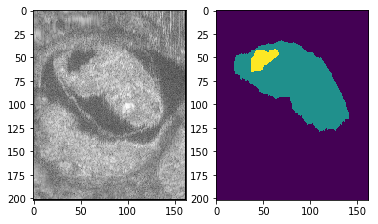

In [43]:
temp = loadnii(0)

fig, ax = plt.subplots(1,2)

slicing_index = 90

ax[0].imshow(temp[0][slicing_index], cmap='gray')
ax[1].imshow(temp[1][slicing_index])
plt.show()

In [15]:
x,y,z = getniishape(106)

print(x, y, z)

210.0 282.0 282.0


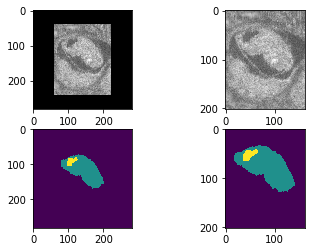

In [29]:
%reload_ext autoreload

image, label = loadallnii(1, 210, 282, 282)